# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
# from ACSPaper.Matching import *
from ACSPaper.ACSPaperUtils import *
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.model_selection import train_test_split

plt.rcParams['pdf.fonttype'] = 42

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v2/'
curr_dir = os.path.join(paper_dir, 'individualized_metabolic_determinants')
make_dir_if_not_exists(curr_dir)
metabolon_dir = os.path.join(curr_dir, 'metabolon')
make_dir_if_not_exists(metabolon_dir)
nigtingale_dir = os.path.join(curr_dir, 'nigtingale')
make_dir_if_not_exists(nigtingale_dir)
os.chdir(paper_dir)

In [2]:
from matplotlib.colors import Normalize

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Load data

In [3]:
full_shap = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/technical_noise/RSCV/LightGBM/metabolomics_shap_ot0.05_full_model/abs_signed_shap.csv', index_col=0)
unknowns_sp = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v5/unknown_pathway_prediction/Supplementary_unknowns_sub_pathways_all_features+shap+levels.csv', index_col=0)
unknowns_sp

,0,Chemical,Androgenic Steroids,"Leucine, Isoleucine and Valine Metabolism",Lysophospholipid,Food Component/Plant,Plasmalogen,Tryptophan Metabolism,Sphingolipid Metabolism,Benzoate Metabolism,...,Phosphatidylcholine (PC),"Fatty Acid, Monohydroxy",Monoacylglycerol,Fibrinogen Cleavage Peptide,Xanthine Metabolism,Fatty Acid Metabolism(Acyl Carnitine),Histidine Metabolism,Lysine Metabolism,Long Chain Fatty Acid,Primary Bile Acid Metabolism
CHEMICAL_ID,,,,,,,,,,,,,,,,,,,,,
X - 01911,0.002830,0.021477,0.007827,0.008157,0.015348,0.667524,0.002502,0.010517,0.010068,0.010226,...,0.003583,0.007665,0.006884,0.009885,0.006142,0.022586,0.015766,0.011145,0.004693,0.025342
X - 07765,0.007109,0.046113,0.058756,0.014391,0.012065,0.159156,0.006009,0.028344,0.007753,0.012569,...,0.009327,0.007596,0.041141,0.008192,0.011227,0.015910,0.048490,0.025683,0.005248,0.153236
X - 11261,0.010323,0.040356,0.008242,0.023650,0.036772,0.088505,0.015523,0.020170,0.096622,0.022039,...,0.032510,0.015141,0.017490,0.008115,0.010622,0.092750,0.053165,0.014039,0.007240,0.012821
X - 11299,0.043503,0.072607,0.025361,0.039468,0.014758,0.106891,0.014279,0.025637,0.041349,0.047347,...,0.024572,0.021881,0.009467,0.010081,0.029183,0.049711,0.036470,0.015887,0.008331,0.010797
X - 11308,0.007034,0.039717,0.152193,0.009015,0.013399,0.088760,0.008995,0.015843,0.012721,0.007626,...,0.004633,0.044369,0.013314,0.006274,0.019347,0.032908,0.009040,0.005961,0.003816,0.113644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X - 24951,0.008656,0.066900,0.225940,0.018227,0.013018,0.019480,0.012527,0.031270,0.011709,0.007307,...,0.008784,0.061398,0.060777,0.014618,0.041926,0.021572,0.017432,0.008916,0.010773,0.017960
X - 24952,0.012235,0.023738,0.016412,0.058563,0.016037,0.096280,0.009760,0.070088,0.023753,0.018395,...,0.018363,0.014126,0.018352,0.046971,0.022684,0.018641,0.090805,0.028356,0.013069,0.041888
X - 24972,0.000656,0.003822,0.947220,0.002969,0.000594,0.004717,0.000884,0.001584,0.001362,0.000715,...,0.001020,0.000882,0.000559,0.007480,0.000601,0.001426,0.001492,0.001381,0.000809,0.001148


In [4]:
updated_metabs1 = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/dataframes/updated_metabs1.csv', index_col=0)
updated_metabs1['SUPER_PATHWAY'] = updated_metabs1['SUPER_PATHWAY'].fillna('Unknowns')
updated_metabs1['SUB_PATHWAY'] = updated_metabs1['SUB_PATHWAY'].fillna('Unknowns')

metabolon_metabolite_name_dic = updated_metabs1['BIOCHEMICAL'].to_dict()
metabolon_metabolite_super_pathway_dic = updated_metabs1['SUPER_PATHWAY'].to_dict()
metabolon_metabolite_sub_pathway_dic = updated_metabs1['SUB_PATHWAY'].to_dict()
metabolon_metabolite_name_dic

{'100016038': '(N(1) + N(8))-acetylspermidine',
 '100006373': '1,2,3-benzenetriol sulfate (1)',
 '100006374': '1,2,3-benzenetriol sulfate (2)',
 '100008903': '1,2-dilinoleoyl-GPC (18:2/18:2)',
 '100009217': '1,2-dilinoleoyl-GPE (18:2/18:2)*',
 '100000657': '1,2-dipalmitoyl-GPC (16:0/16:0)',
 '100001397': '1,3,7-trimethylurate',
 '100001106': '1,3-dimethylurate',
 '100000580': '1,5-anhydroglucitol (1,5-AG)',
 '100001399': '1,7-dimethylurate',
 '100005372': '1-(1-enyl-oleoyl)-GPE (P-18:1)*',
 '100009014': '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*',
 '100009002': '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*',
 '100009009': '1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*',
 '100009069': '1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*',
 '100009007': '1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*',
 '100009005': '1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*',
 '100009160': '1-(1-enyl-palmitoyl)-2-palmitoleoyl-GPC (P-16:0/16:1)*',
 '100009162': '1-(1

In [5]:
pnp_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures', 'pnp_data_metabolon.csv'), index_col=0)
acs_data_metabolon = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures', 'acs_data_metabolon.csv'), index_col=0)
acs_data_metabolon['combined_outcome'] = acs_data_metabolon[['Acute MI', 'Acute stroke', 'Acute limb event', 'Unplanned PCI', 'New-onset HF', 'New-onset Afib', 'CV hospitalization including chest pain', 'CV death',]].any(1)
acs_data_metabolon['Acute_MI_or_Stroke'] = acs_data_metabolon[['Acute MI', 'Acute stroke']].any(1)
acs_data_metabolon['combined_cvd_outcome'] = acs_data_metabolon[['Acute MI', 'Acute stroke', 'Unplanned PCI', 'CV death',]].any(1)
acs_data_metabolon['Admission Diagnosis: STEMI vs UA'] = acs_data_metabolon['Admission Diagnosis: STEMI'].values
acs_data_metabolon.loc[acs_data_metabolon['Admission Diagnosis: NSTEMI'] == 1, 'Admission Diagnosis: STEMI vs UA'] = np.nan


# circ_heatmap_df_sorted = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures', 'metabolon', 'circ_heatmap_df_sorted.csv'), index_col=0)
# circ_heatmap_df_sorted = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures', 'metabolon', 'circ_heatmap_df_sorted_MMC-DM.csv'), index_col=0)
circ_heatmap_df_sorted = pd.read_csv(os.path.join(paper_dir, 'serum_metabolomics_signatures', 'metabolon', 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0)

# circ_heatmap_df_sorted = circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)) < 0.05/circ_heatmap_df_sorted.shape[0]].copy()
# circ_heatmap_df_sorted = circ_heatmap_df_sorted[fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)), alpha=0.05)[0]].copy()

circ_heatmap_df_sorted.shape

Columns (43,3261,3277) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (10,23,30,33,40,96,97,101,107,110,111,112,131,132,133,134,135,136,137,138,139,140,141,142,143,145,148,149,150,151,152,153,155,157,159,169,170,179,184) have mixed types.Specify dtype option on import or set low_memory=False.


(916, 6)

## remove storage time correlated metabolties

In [49]:
# storage_bad_metabs = ['X - 12462',
#  'X - 18914',
#  '100021107',
#  '100020903',
#  '100000487',
#  '100020274',
#  '100020908',
#  '171',
#  '100020275',
#  'X - 17010',
#  '1004',
#  '100001323',
#  '1099',
#  '234',
#  '1141',
#  '100001296',
#  '100001334',
#  '100015966',
#  '100015967',
#  '100005372',
#  '432',
#  'X - 18249',
#  '100006644']

IndentationError: unexpected indent (<ipython-input-49-54ed511b8f6c>, line 2)

In [53]:
storage_bad_metabs = pd.read_pickle(os.path.join('../data', 'storage_time_bad_metabs_bonf.pkl'))

In [56]:
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]

In [7]:
with open(os.path.join(paper_dir, 'metabolon_molecules_to_remove.pkl'), 'rb') as handle:
    metabolon_molecules_to_remove = pickle.load(handle)

In [457]:
# circ_heatmap_df_sorted = circ_heatmap_df_sorted.drop(metabolon_molecules_to_remove, errors='ignore')
# metabolon_molecules_to_remove

# Match samples

In [17]:
# for every ACS subject, create a subset of healthy control, according to: same sex, middle of age group (+- 3/5/10 years)
# for every metabolite:

def get_matched_samples(case, controls, match_by={'Age':5, 'gender':'bin'}):
#     case = pd.Series(case)
    matches = pd.Series(True, controls.index)
    for col in match_by:
        if match_by[col] == 'bin':
            matches = matches & (controls[col] == case[col].values[0])
#             print (col, matches.sum())
        elif match_by[col] > 0:
            matches = matches & (abs(controls[col]-case[col].values[0]) < match_by[col])
#             print (col, matches.sum())
    return controls.loc[matches, match_by.keys()]

a = pd.DataFrame(0, index=[0], columns=['a', 'b'])
b = pd.DataFrame(np.random.normal(0, 1, (10, 2)), index=range(10), columns=['a', 'b'])
b['b'] = [0]*5 + [1]*5
print (a, b)

get_matched_samples(a, b, match_by={'a':1, 'b':'bin'})

   a  b
0  0  0           a  b
0  0.126568  0
1 -0.132541  0
2  1.542019  0
3  1.173875  0
4  1.156902  0
5  0.901579  1
6 -0.262898  1
7  0.511622  1
8  0.214764  1
9  1.608570  1


,a,b
0,0.126568,0
1,-0.132541,0


In [375]:
background_samples = {}
for age_diff in range(3, 10, 1):
    background_samples[age_diff] = {}
    for case in tqdm_notebook(acs_data_metabolon.index[:]):
        background_samples[age_diff][case] = get_matched_samples(pd.DataFrame(acs_data_metabolon.loc[case]).T, pnp_data_metabolon, match_by={'Age':age_diff, 'gender':'bin'})
        
with open(os.path.join(curr_dir, 'background_samples.pkl'), 'wb') as handle:
    pickle.dump(background_samples, handle)
background_samples_all = background_samples.copy()

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Healthy-ACS by age+sex+bmi

In [18]:
background_samples_age_sex_bmi = {}
for case in tqdm_notebook(acs_data_metabolon.index[:]):
    background_samples_age_sex_bmi[case] = get_matched_samples(pd.DataFrame(acs_data_metabolon.loc[case]).T, 
                                                               pnp_data_metabolon, 
                                                               match_by={'Age':5, 'gender':'bin', 'bmi':3})
        
with open(os.path.join(curr_dir, 'background_samples_age_sex_bmi.pkl'), 'wb') as handle:
    pickle.dump(background_samples_age_sex_bmi, handle)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## Healthy metabollicaly healthy vs impaired

In [19]:
healthy_controls = pnp_data_metabolon[(pnp_data_metabolon['bmi']<=35) & 
                                      (pnp_data_metabolon['Dyslipidemia']==False) & 
                                      (pnp_data_metabolon['Hypertension']==False) &
                                      (pnp_data_metabolon['DM']==False)].index
metabollicaly_impaired_controls = pnp_data_metabolon[~pnp_data_metabolon.index.isin(healthy_controls)].index

In [21]:
pnp_background_samples_age_sex_bmi = {}
for case in tqdm_notebook(metabollicaly_impaired_controls):
    pnp_background_samples_age_sex_bmi[case] = get_matched_samples(pd.DataFrame(pnp_data_metabolon.loc[case]).T, 
                                                               pnp_data_metabolon.loc[healthy_controls], 
                                                               match_by={'Age':5, 'gender':'bin', 'bmi':3})
        
with open(os.path.join(curr_dir, 'metab_healthy-impaired_background_samples_age_sex_bmi.pkl'), 'wb') as handle:
    pickle.dump(pnp_background_samples_age_sex_bmi, handle)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


## random healthy split

In [22]:
np.random.seed(0)
random_healthy_cases = np.random.choice(pnp_data_metabolon.index, 150, replace=False)
random_healthy_controls = list(set(pnp_data_metabolon.index)-set(random_healthy_cases))

In [23]:
random_background_samples_age_sex_bmi = {}
for case in tqdm_notebook(random_healthy_cases):
    random_background_samples_age_sex_bmi[case] = get_matched_samples(pd.DataFrame(pnp_data_metabolon.loc[case]).T, 
                                                               pnp_data_metabolon.loc[random_healthy_controls], 
                                                               match_by={'Age':5, 'gender':'bin', 'bmi':3})
        
with open(os.path.join(curr_dir, 'random_background_samples_age_sex_bmi.pkl'), 'wb') as handle:
    pickle.dump(random_background_samples_age_sex_bmi, handle)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Plot Age ranges for matched controls (years)

In [888]:
with open(os.path.join(curr_dir, 'background_samples.pkl'), 'rb') as handle:
    background_samples = pickle.load(handle)
    background_samples_all = background_samples.copy()

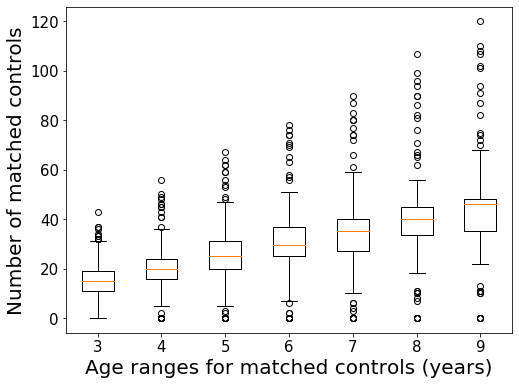

In [336]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.boxplot([[background_samples[s][c].shape[0] for c in background_samples[s]] for s in background_samples])
ax.set_xticklabels(background_samples.keys())
ax.set_ylabel('Number of matched controls', fontsize=20)
ax.set_xlabel('Age ranges for matched controls (years)', fontsize=20)
ax.tick_params(labelsize=15)

plt.savefig(os.path.join(metabolon_dir, 'Supp_figure_ncontrols_vs_age_diff_small.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Supp_figure_ncontrols_vs_age_diff.png'), dpi=1000, bbox_inches='tight')

In [67]:
case_data = acs_data_metabolon.copy()
control_data = pnp_data_metabolon.copy()
background_samples = background_samples_age_sex_bmi.copy()
save_path = 'Supplementary_table-individual_level_scores_v2_healthy-ACS.csv'

# case_data = pnp_data_metabolon.loc[metabollicaly_impaired_controls].copy() 
# control_data = pnp_data_metabolon.loc[healthy_controls].copy()
# background_samples = pnp_background_samples_age_sex_bmi.copy()
# save_path = 'Supplementary_table-individual_level_scores_v2_healthy-metab_impaired.csv'

# case_data = pnp_data_metabolon.loc[random_healthy_cases].copy()
# control_data = pnp_data_metabolon.loc[random_healthy_controls].copy()
# background_samples = random_background_samples_age_sex_bmi.copy()
# save_path = 'Supplementary_table-individual_level_scores_v2_healthy-random.csv'


good_acs_metabolomics_origin = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1).columns)
bad_acs_metabolomics_origin = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1).columns)
all_acs_metabolomics_origin = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1).columns)
good_acs_metabolomics_stds = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].drop('Healthy-ACS', axis=1).index)
bad_acs_metabolomics_stds = pd.DataFrame(index=case_data.index, columns=circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].drop('Healthy-ACS', axis=1).index)

clip_value = 3
top_n = 100
age_diff = 3
r2_th = 0.05
samples_to_use = [s for s in background_samples if background_samples[s].shape[0]>2]


for case in samples_to_use:
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    temp_control_metabs = control_data.loc[background_samples[case].index, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    case_stds = ((case_metabs - temp_control_metabs.mean()) / temp_control_metabs.std()).astype(float)
    case_stds[case_stds<0] = 0
    case_stds[case_stds == np.inf] = np.nan
    case_stds.clip(upper=clip_value, inplace=True)
    case_determinants_mean =(circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].drop('Healthy-ACS', axis=1) > r2_th)\
                                                .astype(float).apply(lambda x: x*case_stds.nlargest(top_n).reindex(case_stds.index)).mean()
    bad_acs_metabolomics_origin.loc[case, :] = case_determinants_mean.values
    bad_acs_metabolomics_stds.loc[case, :] = case_stds.values
    
for case in samples_to_use:
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    temp_control_metabs = control_data.loc[background_samples[case].index, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    case_stds = ((temp_control_metabs.mean() - case_metabs) / temp_control_metabs.std()).astype(float)
    case_stds[case_stds<0] = 0
    case_stds[case_stds == np.inf] = np.nan
    case_stds.clip(upper=clip_value, inplace=True)
    case_determinants_mean =(circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].drop('Healthy-ACS', axis=1) > r2_th)\
                                                .astype(float).apply(lambda x: x*case_stds.nlargest(top_n).reindex(case_stds.index)).mean()
    good_acs_metabolomics_origin.loc[case, :] = case_determinants_mean.values
    good_acs_metabolomics_stds.loc[case, :] = case_stds.values
    
# combined
for case in samples_to_use:
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    temp_control_metabs = control_data.loc[background_samples[case].index, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']>0].index]
    case_stds1 = ((case_metabs - temp_control_metabs.mean()) / temp_control_metabs.std()).astype(float)
    case_stds1[case_stds1<0] = 0
    case_metabs = case_data.loc[case, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    temp_control_metabs = control_data.loc[background_samples[case].index, circ_heatmap_df_sorted[circ_heatmap_df_sorted['Healthy-ACS']<0].index]
    case_stds2 = ((temp_control_metabs.mean() - case_metabs) / temp_control_metabs.std()).astype(float)
    case_stds2[case_stds2<0] = 0
    case_stds = pd.concat((case_stds1, case_stds2), axis=0, sort=False)
    case_stds[case_stds == np.inf] = np.nan
    case_stds.clip(upper=clip_value, inplace=True)
    case_determinants_mean =(circ_heatmap_df_sorted.drop('Healthy-ACS', axis=1) > r2_th)\
                                                .astype(float).apply(lambda x: x*case_stds.nlargest(top_n).reindex(case_stds.index)).mean()
    all_acs_metabolomics_origin.loc[case, :] = case_determinants_mean.values
    
bad_acs_metabolomics_origin = bad_acs_metabolomics_origin.astype(float)
good_acs_metabolomics_origin = good_acs_metabolomics_origin.astype(float)
all_acs_metabolomics_origin = all_acs_metabolomics_origin.astype(float)
bad_acs_metabolomics_stds = bad_acs_metabolomics_stds.astype(float)
good_acs_metabolomics_stds = good_acs_metabolomics_stds.astype(float)

metabolomics_origins = pd.concat((good_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'ACS-depleted '+k for k in good_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns}),
                  bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'ACS-enriched '+k for k in bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns}),
                  all_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'All '+k for k in bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns})), axis=1).dropna()

metabolomics_origins.to_csv(os.path.join(metabolon_dir, save_path))

# compute determinant scores

In [63]:
metabolomics_origins_acs = pd.read_csv(os.path.join(metabolon_dir, 'Supplementary_table-individual_level_scores_v2_healthy-ACS.csv'), index_col=0)
metabolomics_origins_metab = pd.read_csv(os.path.join(metabolon_dir, 'Supplementary_table-individual_level_scores_v2_healthy-metab_impaired.csv'), index_col=0)
metabolomics_origins_random = pd.read_csv(os.path.join(metabolon_dir, 'Supplementary_table-individual_level_scores_v2_healthy-random.csv'), index_col=0)

# Analyse

## associations with features

In [64]:
print ('bad\n', circ_heatmap_df_sorted.loc[circ_heatmap_df_sorted['Healthy-ACS']>0].mean())
print ('good\n', circ_heatmap_df_sorted.loc[circ_heatmap_df_sorted['Healthy-ACS']<0].mean())
# good_acs_metabolomics_origin

bad
 Healthy-ACS                    2.005162
DM-ACS                         0.149477
Microbiome r2                  0.017446
Diet r2                        0.034311
Traditional Risk Factors r2    0.055046
Genetics r2                    0.012028
dtype: float64
good
 Healthy-ACS                   -3.013995
DM-ACS                         0.044963
Microbiome r2                  0.032356
Diet r2                        0.062029
Traditional Risk Factors r2    0.054213
Genetics r2                    0.009473
dtype: float64


In [21]:
# # old results - do not delete
# features2check = ['gender', 'Age', 'Number of vessels involved', 'Admission Diagnosis: STEMI', 'Past CVA/TIA', 'combined_outcome', 'Acute_MI_or_Stroke', 'Glucose Disorder: DM2', 'Known CAD', 'eGFR by CKD-EPI']
# r2s = [r2 for r2 in good_acs_metabolomics_origin.columns if r2.endswith('r2')]
# good_p, bad_p, all_p = pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s)
# for col in features2check:
# # for col in acs_data_metabolon.columns[:237]:
#     for r2 in r2s:
#         for name, df, p_list in zip(['good', 'bad', 'all'], [good_acs_metabolomics_origin, bad_acs_metabolomics_origin, all_origin], [good_p, bad_p, all_p]):
#             try:
#                 r, p = spearmanr(acs_data_metabolon[col], df[r2], nan_policy='omit')
#                 p_list.loc[col, r2] = p
#             except:
#                 continue
#             if p<0.05:
#                 print (name, col, r2, '%0.2g'%r, '%0.2g'%p)

bad gender Genetics r2 0.25 0.0029
good Age Traditional Risk Factors r2 0.27 0.0009
all Age Traditional Risk Factors r2 0.23 0.0058
bad Age Genetics r2 0.33 4.3e-05
bad Number of vessels involved Diet r2 0.18 0.029
bad Number of vessels involved Genetics r2 0.23 0.0049
all Number of vessels involved Genetics r2 0.2 0.018
good Acute_MI_or_Stroke Microbiome r2 0.18 0.033
all Acute_MI_or_Stroke Microbiome r2 0.19 0.026
good Acute_MI_or_Stroke Diet r2 0.19 0.026
all Acute_MI_or_Stroke Diet r2 0.21 0.015
good Acute_MI_or_Stroke Genetics r2 0.21 0.013
all Acute_MI_or_Stroke Genetics r2 0.18 0.038
bad Glucose Disorder: DM2 Microbiome r2 0.28 0.0008
bad Glucose Disorder: DM2 Diet r2 0.36 1.1e-05
good Glucose Disorder: DM2 Genetics r2 0.21 0.011
all Glucose Disorder: DM2 Genetics r2 0.18 0.035
bad Known CAD Diet r2 0.2 0.018
good eGFR by CKD-EPI Genetics r2 0.29 0.00037
all eGFR by CKD-EPI Genetics r2 0.24 0.0054


In [1326]:
# # old results - with 916 metabolites
# features2check = ['gender', 'Age', 'Number of vessels involved', 'Admission Diagnosis: STEMI', 'Past CVA/TIA', 
#                   'combined_outcome', 'Acute_MI_or_Stroke', 'Glucose Disorder: DM2', 'Known CAD', 'eGFR by CKD-EPI', 'combined_cvd_outcome']
# r2s = [r2 for r2 in good_acs_metabolomics_origin.columns if r2.endswith('r2')]
# good_p, bad_p, all_p = pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s)
# for col in features2check:
# # for col in acs_data_metabolon.columns[:237]:
#     for r2 in r2s:
#         for name, df, p_list in zip(['good', 'bad', 'all'], [good_acs_metabolomics_origin, bad_acs_metabolomics_origin, all_acs_metabolomics_origin], [good_p, bad_p, all_p]):
#             try:
#                 r, p = spearmanr(acs_data_metabolon[col], df[r2], nan_policy='omit')
#                 p_list.loc[col, r2] = p
#             except:
#                 continue
#             if p<0.02:
#                 print (name, col, r2, '%0.2g'%r, '%0.2g'%p)

good Age Microbiome r2 -0.23 0.008
all Age Microbiome r2 -0.21 0.012
good Age Diet r2 -0.21 0.015
bad Age Diet r2 0.22 0.01
all Age Diet r2 -0.21 0.015
good Age Traditional Risk Factors r2 0.29 0.00061
all Age Traditional Risk Factors r2 0.28 0.0012
bad Age Genetics r2 0.24 0.005
bad combined_outcome Genetics r2 -0.28 0.00085
bad Acute_MI_or_Stroke Genetics r2 -0.25 0.004
bad Glucose Disorder: DM2 Microbiome r2 0.38 5.7e-06
good Glucose Disorder: DM2 Genetics r2 0.29 0.0007
all Glucose Disorder: DM2 Genetics r2 0.25 0.0031
good Known CAD Diet r2 -0.21 0.014
all Known CAD Diet r2 -0.2 0.018
all eGFR by CKD-EPI Microbiome r2 0.24 0.006
good eGFR by CKD-EPI Diet r2 0.25 0.0032
all eGFR by CKD-EPI Diet r2 0.22 0.0099
good combined_cvd_outcome Traditional Risk Factors r2 0.28 0.0011
all combined_cvd_outcome Traditional Risk Factors r2 0.21 0.012
bad combined_cvd_outcome Genetics r2 -0.26 0.0027


In [68]:
# new results - with 892 metabolites
features2check = ['gender', 'Age', 'Number of vessels involved', 'Admission Diagnosis: STEMI', 'Past CVA/TIA', 
                  'combined_outcome', 'Acute_MI_or_Stroke', 'Glucose Disorder: DM2', 'Known CAD', 'eGFR by CKD-EPI', 'combined_cvd_outcome']
r2s = [r2 for r2 in good_acs_metabolomics_origin.columns if r2.endswith('r2')]
good_p, bad_p, all_p = pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s), pd.DataFrame(index=features2check, columns=r2s)
for col in features2check:
# for col in acs_data_metabolon.columns[:237]:
    for r2 in r2s:
        for name, df, p_list in zip(['good', 'bad', 'all'], [good_acs_metabolomics_origin, bad_acs_metabolomics_origin, all_acs_metabolomics_origin], [good_p, bad_p, all_p]):
            try:
                r, p = spearmanr(acs_data_metabolon[col], df[r2], nan_policy='omit')
                p_list.loc[col, r2] = p
            except:
                continue
            if p<0.02:
                print (name, col, r2, '%0.2g'%r, '%0.2g'%p)

good Age Microbiome r2 -0.21 0.013
all Age Microbiome r2 -0.22 0.01
bad Age Diet r2 0.21 0.014
all Age Diet r2 -0.2 0.019
good Age Traditional Risk Factors r2 0.3 0.00043
all Age Traditional Risk Factors r2 0.3 0.00045
bad Age Genetics r2 0.25 0.0035
all Age Genetics r2 0.2 0.017
bad combined_outcome Genetics r2 -0.28 0.0012
bad Acute_MI_or_Stroke Genetics r2 -0.23 0.0065
bad Glucose Disorder: DM2 Microbiome r2 0.4 2e-06
good Glucose Disorder: DM2 Genetics r2 0.27 0.0018
all Glucose Disorder: DM2 Genetics r2 0.29 0.00084
good Known CAD Diet r2 -0.21 0.016
all Known CAD Diet r2 -0.24 0.0063
all eGFR by CKD-EPI Microbiome r2 0.22 0.011
good eGFR by CKD-EPI Diet r2 0.24 0.0046
all eGFR by CKD-EPI Diet r2 0.22 0.012
good combined_cvd_outcome Traditional Risk Factors r2 0.28 0.0012
all combined_cvd_outcome Traditional Risk Factors r2 0.21 0.014
bad combined_cvd_outcome Genetics r2 -0.25 0.004


In [43]:
# compare STEMI vs UA
for col in metabolomics_origins_acs.columns[:-1]:
    print (col)
    r, p = spearmanr(acs_data_metabolon.loc[metabolomics_origins_acs.index, 'Admission Diagnosis: STEMI vs UA'], 
                     metabolomics_origins_acs[col], nan_policy='omit')
    print (r, p)
# metabolomics_origins_acs

ACS-depleted Microbiome r2
0.08658504624177946 0.42247538333518075
ACS-depleted Diet r2
0.08973359337784416 0.4057370395723914
ACS-depleted Traditional Risk Factors r2
-0.1537540518111599 0.1526487988164167
ACS-depleted Genetics r2
0.00892104066393038 0.934255614830915
ACS-enriched Microbiome r2
-0.07713940483358533 0.475010466429981
ACS-enriched Diet r2
0.06244618486528337 0.563273705955609
ACS-enriched Traditional Risk Factors r2
0.1422093789789226 0.18626933464285844
ACS-enriched Genetics r2
-0.0750403734095422 0.487145182549823
All Microbiome r2
0.0519519426899475 0.6307233606142757
All Diet r2
0.07399085769752063 0.49327364577521704
All Traditional Risk Factors r2
-0.05195102774506767 0.6307293865603646
All Genetics r2
-0.06927017190710952 0.5213332335334392


In [71]:
mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon['Glucose Disorder: DM2']==1, 'Microbiome r2'].dropna(), 
             bad_acs_metabolomics_origin.loc[acs_data_metabolon['Glucose Disorder: DM2']==0, 'Microbiome r2'].dropna())
mannwhitneyu(good_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==1, 'Traditional Risk Factors r2'].dropna(), 
             good_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==0, 'Traditional Risk Factors r2'].dropna())
mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==1, 'Genetics r2'].dropna(), 
             bad_acs_metabolomics_origin.loc[acs_data_metabolon['combined_cvd_outcome']==0, 'Genetics r2'].dropna())

MannwhitneyuResult(statistic=411.0, pvalue=0.0022168357679634857)

In [104]:
good_acs_metabolomics_stds.shape[1]
# bad_acs_metabolomics_stds.shape[1]

559

## distributions and comparison to metab impaired

In [73]:
metabolomics_origins_metab['group'] = 'Metab. impaired vs control'
metabolomics_origins_acs['group'] = 'ACS vs control'
metabolomics_origins_random['group'] = 'Control vs control (random)'
metabolomics_origins = pd.concat((metabolomics_origins_acs, metabolomics_origins_metab, metabolomics_origins_random), axis=0)

Traditional Risk Factors 0.00010727528353952522
Diet 1.682554103025616e-09
Microbiome 3.6988241143918196e-07
Genetics 0.0017836717194557056


Text(-0.1, 1, 'd')

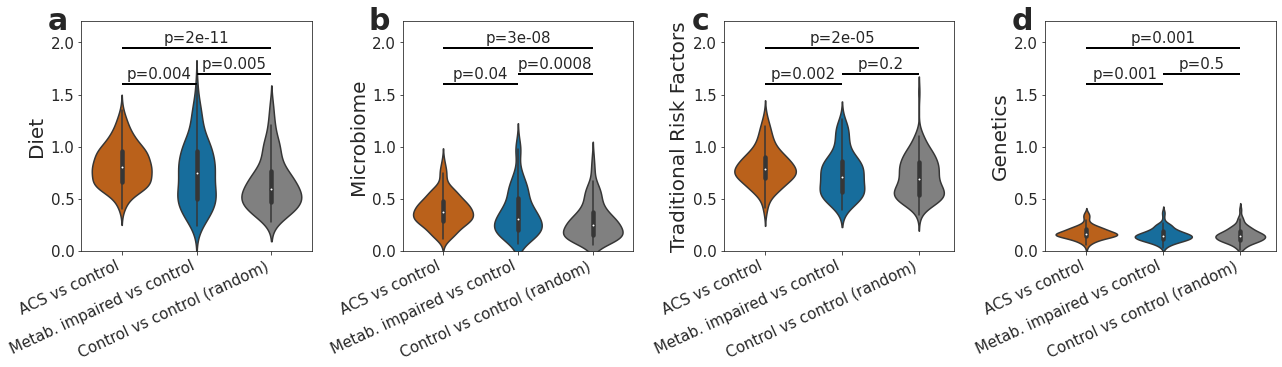

In [101]:
sns.set_style('ticks')
fig, axes = plt.subplots(1, 4, figsize=(18, 5))
labels_fontsize = 20
tick_fontsize = 15


ax=axes[2]
r2 = 'Traditional Risk Factors'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

ax=axes[0]
r2 = 'Diet'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

ax=axes[1]
r2 = 'Microbiome'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

ax=axes[3]
r2 = 'Genetics'
sns.violinplot(x='group', data=metabolomics_origins, y='All ' + r2 + ' r2', ax=ax, 
               palette=[acs_color, healthy_color, 'grey'])
ax.set_ylabel(r2, fontsize=labels_fontsize)
# ax.set_xlabel('Group comparison', fontsize=labels_fontsize)
ax.set_xlabel('', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=25, ha='right')
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylim((0., 2.2))
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna())
xx=0.5
ax.text(xx, 1.65,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.6, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1.5
ax.text(xx, 1.75,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.7, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')
t, p = mannwhitneyu(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
                   metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
xx=1
ax.text(xx, 2,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.95, xmin=xx-1, xmax=xx+1, linewidth=2, color='black')
k, p = kruskal(metabolomics_origins.loc[metabolomics_origins['group']=='ACS vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Metab. impaired vs control', 'All ' + r2 + ' r2'].dropna(),
               metabolomics_origins.loc[metabolomics_origins['group']=='Control vs control (random)', 'All ' + r2 + ' r2'].dropna())
print(r2, p)

fig.tight_layout()
plt.text(-0.1, 1, 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.1, 1, 'd', ha='center', va='center', transform=axes[3].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Figure3.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Figure3.pdf'), dpi=300, bbox_inches='tight')

KruskalResult(statistic=12.175384900760529, pvalue=0.002270642494344168)

# Plot

## homogenic patient heatmap

In [75]:
homogenic_risk_factors = acs_data_metabolon[(acs_data_metabolon['LDL'] <= 130) 
                                            & (acs_data_metabolon['LDL'] >= 70) 
                                            & (acs_data_metabolon['HbA1C'] >=1) 
                                            & (acs_data_metabolon['HbA1C'] <= 6) 
                                            & (acs_data_metabolon['Age'] >= 60) 
                                            & (acs_data_metabolon['Age'] <= 70) 
                                            & (acs_data_metabolon['gender'] == 1)].dropna(subset=['381']).index
#                                            & (acs_data_metabolon['Admission Diastolic BP']<85) 
#                                            & (acs_data_metabolon['Admission Systolic BP']<135)
homogenic_risk_factors.shape

(17,)

In [76]:
good_acs_metabolomics_origin.apply(lambda x: (x-x.mean())/x.std()).loc[homogenic_risk_factors] # [3610542, 3443343] [3339392, 3168327] [3031317, 3655837]

,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
RegistrationCode,,,,,
3401349,0.665323,-0.712983,0.431105,2.502917,2.410853
3485604,0.707313,0.242595,-0.766378,-0.514225,0.132643
3443343,0.781827,0.598804,0.085192,1.083528,0.312098
3716167,0.479035,-1.395534,-0.415012,0.887888,0.161278
3991818,1.390088,-0.094764,1.151496,0.612616,-0.174160
3168327,1.685876,0.525517,0.084042,0.701662,-0.513084
3909165,0.212981,-0.403478,0.382365,0.271186,-0.227012
3493526,0.636921,-0.600540,0.115137,0.529085,-0.679166
3849571,0.808228,-0.007786,0.083022,1.964737,-0.989692


In [1118]:
bad_acs_metabolomics_origin.apply(lambda x: (x-x.mean())/x.std()).loc[homogenic_risk_factors]#.loc[[3493526, 3909165, 3485604]] [3493526, 3485604]

,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
RegistrationCode,,,,,
3401349,0.517219,-1.256603,0.687712,0.652846,0.688805
3485604,-0.187074,-0.265719,1.172384,0.618005,-0.213746
3443343,-0.771991,-0.947633,-1.167610,-1.355677,-1.721963
3716167,0.220056,-1.327964,-1.145202,0.597823,-0.000063
3991818,-0.638522,2.377958,-0.809712,-0.667645,0.064638
3168327,-0.458470,-1.939532,-0.479686,0.251082,-0.164311
3909165,-0.157556,-1.203301,-1.142366,-0.817061,0.483492
3493526,-0.145192,3.040246,-0.029211,0.060110,-0.146217
3849571,-1.435167,-0.935091,-0.819778,-0.936647,-0.650865


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
`distplot` is a deprecated function and will

<Figure size 720x720 with 0 Axes>

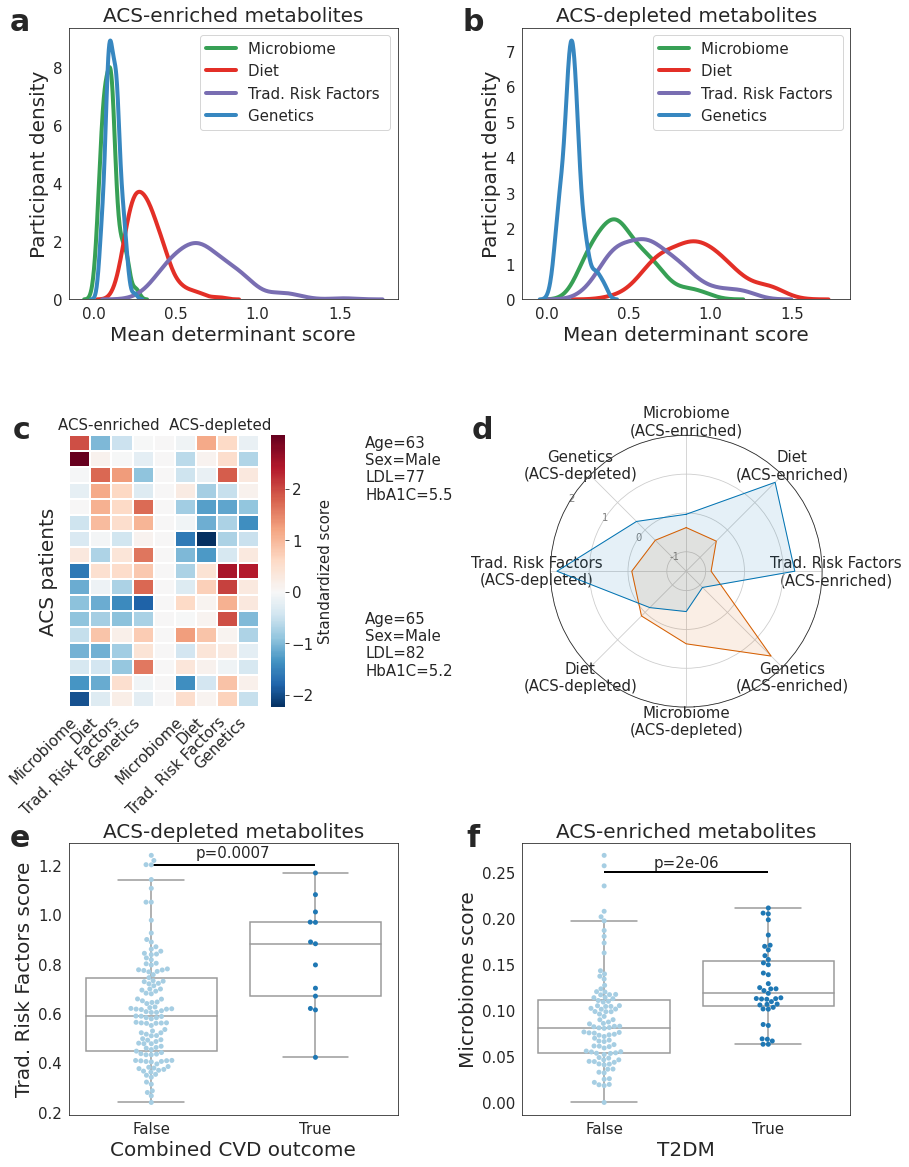

In [82]:
df1 = pd.concat((bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:(k).replace('Traditional', 'Trad.').split(' r2')[0]+'\n(ACS-enriched)' for k in bad_acs_metabolomics_origin.columns}), 
                          good_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:(k).replace('Traditional', 'Trad.').split(' r2')[0]+'\n(ACS-depleted)' for k in bad_acs_metabolomics_origin.columns})), axis=1).dropna()

df1 = df1.apply(lambda x: (x-x.mean())/x.std())
df1 = df1.loc[homogenic_risk_factors]
cg = sns.clustermap(df1, 
                          metric='euclidean', col_cluster=False)
plt.clf()
df1 = df1.iloc[cg.dendrogram_row.reordered_ind, :]
df = df1.copy()

fig = plt.figure(figsize=(14, 20))

gs = gridspec.GridSpec(3, 9, wspace=.6, hspace=.5)

bad_density = fig.add_subplot(gs[0, :4])
good_density = fig.add_subplot(gs[0, 5:])
heatmap = fig.add_subplot(gs[1, :3])
polar = fig.add_subplot(gs[1, 5:], projection='polar')
boxplot_nv = fig.add_subplot(gs[2, :4])
boxplot_t2d = fig.add_subplot(gs[2, 5:])

# fig, axes = plt.subplots(3, 2, figsize=(11, 15))
labels_fontsize=20
tick_fontsize=15
colors = sns.color_palette('Paired', 10)
colors = [sns.color_palette('Greens', 5)[3], sns.color_palette('Reds', 5)[3], sns.color_palette('Purples', 5)[3], sns.color_palette('Blues', 5)[3]]
feature_colors = {'Traditional Risk Factors r2': sns.color_palette('Purples', 5)[3], 'Diet r2': sns.color_palette('Reds', 5)[3], 
                  'Microbiome r2': sns.color_palette('Greens', 5)[3], 'Genetics r2': sns.color_palette('Blues', 5)[3]}


max_value = max(bad_acs_metabolomics_origin.max().max(), good_acs_metabolomics_origin.max().max())
ax = bad_density
for r2, color in zip(r2s, colors):
    sns.distplot(bad_acs_metabolomics_origin[r2], label=r2.split('r2')[0].replace('Traditional', 'Trad.'), hist=False, ax=ax, color=color, kde_kws={"lw": 4, 'alpha':0.7})
ax.set_xlabel('Mean determinant score', fontsize=labels_fontsize)
ax.set_ylabel('Participant density', fontsize=labels_fontsize)
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.legend(loc='best', fontsize=tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax = good_density
for r2, color in zip(r2s, colors):
    sns.distplot(good_acs_metabolomics_origin[r2], label=r2.split('r2')[0].replace('Traditional', 'Trad.'), hist=False, ax=ax, color=color, kde_kws={"lw": 4, 'alpha':0.7})
ax.set_xlabel('Mean determinant score', fontsize=labels_fontsize)
ax.set_ylabel('Participant density', fontsize=labels_fontsize)
ax.set_title('ACS-depleted metabolites', fontsize=labels_fontsize)
ax.legend(loc='best', fontsize=tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)
ax.set_xlim(bad_density.get_xlim())

colors = sns.color_palette('Paired', 10)

ax = boxplot_nv
c='combined_cvd_outcome'
r2 = 'Traditional Risk Factors r2'
origins = good_acs_metabolomics_origin.copy()
sns.boxplot(data=pd.concat((acs_data_metabolon[c], origins[r2]), axis=1), x=c, y=r2, ax=ax, palette=['white'], showfliers=False)
sns.swarmplot(data=pd.concat((acs_data_metabolon[c], origins[r2]), axis=1), x=c, y=r2, ax=ax, palette=colors)
ax.set_title('ACS-depleted metabolites', fontsize=labels_fontsize)
ax.set_xlabel('Combined CVD outcome', fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0].replace('Traditional', 'Trad.') + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
# ax.set_ylim((0, 0.018))
# r, p = spearmanr(acs_data_metabolon[c], bad_acs_metabolomics_origin[r2], nan_policy='omit')
# add_text_at_corner(ax, r'Spearman $\rho$=%0.2g, p=%0.2g'%(r, bad_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)
t, p = mannwhitneyu(origins.loc[acs_data_metabolon[c]==1, r2].dropna(), origins.loc[acs_data_metabolon[c]==0, r2].dropna())
xx=0.5
ax.text(xx, 1.23,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=1.2, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')


ax = boxplot_t2d
c='Glucose Disorder: DM2'
r2 = 'Microbiome r2'
sns.boxplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=['white'], showfliers=False)
sns.swarmplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=colors)
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.set_xlabel('T2DM', fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0] + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
ax.set_xticklabels([False, True])
# ax.set_ylim((0, 0.018))
# r, p = spearmanr(acs_data_metabolon[c], bad_acs_metabolomics_origin[r2], nan_policy='omit')
# add_text_at_corner(ax, r'Spearman $\rho$=%0.2g, p=%0.2g'%(r, bad_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)
t, p = mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==1, r2].dropna(), bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==0, r2].dropna())
xx=0.5
ax.text(xx, 0.255,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=0.25, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')



# Libraries
from math import pi


couple = [3031317, 3655837] #[3031317, 3655837] [3339392, 3168327]


sns.set_style('white')
ax = heatmap# ax = plt.subplot(131)
norm1 = MidpointNormalize(vmin=df.min().min(), 
                          vmax=df.max().max(), 
                          midpoint=0)

heatmap_df = df.copy()
heatmap_df[''] = [0]*df.shape[0]
heatmap_df = heatmap_df.loc[:, df.columns[:4].tolist() + [''] + df.columns[4:].tolist()]
sns.set_style('white')
sns.heatmap(heatmap_df.rename(columns={k:k.split('\n')[0] for k in df.columns}), cmap='RdBu_r', ax=ax, norm=norm1, 
            linecolor='white', linewidth=1, cbar_kws={'label': 'Standardized score', 'ticks':[-2, -1, 0, 1, 2]})
ax.figure.axes[-1].set_ylabel('Standardized score', size=tick_fontsize)
ax.figure.axes[-1].tick_params(labelsize=tick_fontsize)
# ax.figure.axes[-1].set_xticks([-1, 0, 1])
ax.set_yticklabels([])
ax.set_ylabel('ACS patients', fontsize=labels_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=tick_fontsize, ha='right')
# for _, spine in ax.spines.items():
#     spine.set_visible(True)
#     spine.set_linewidth(3)
#     spine.set_color('white')
# ax.add_patch(Rectangle((4, 0), 0, df.shape[0], fill=False, edgecolor='white', lw=5))
ax.set_title('ACS-enriched  ACS-depleted', fontsize=tick_fontsize)
ax.tick_params(labelsize=tick_fontsize)

ax.text(14, 4, 'Age=63\nSex=Male\nLDL=77\nHbA1C=5.5', fontsize=tick_fontsize)
ax.text(14, df.shape[0]-2, 'Age=65\nSex=Male\nLDL=82\nHbA1C=5.2', fontsize=tick_fontsize)
 
# Set data
# df = df.loc[couple].filter(regex='depleted')
df = df.loc[couple]
 
#  df = df.rename({k:k.replace('good ', '').replace('bad ', '')})
 
# ------- PART 1: Create background
 
# number of variable
categories=list(df)
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# ax.plot([0, 1], [0, 1])
# ax = plt.subplot(133, projection='polar')
# ax = plt.subplot(111, polar=True)
# ax = axes[0]
ax = polar
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
# Draw one axe per variable + add labels labels yet
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, ha='center', fontsize=tick_fontsize)
 
# Draw ylabels
ax.set_rlabel_position(300)
ax.set_yticks([-2, -1, 0, 1, 2])
ax.set_yticklabels(["-2", "-1","0","1", '2'], color="grey", size=10)
ax.set_ylim(-1.5, 2)
 
 
# ------- PART 2: Add plots
 
# Plot each individual = each line of the data
# I don't do a loop, because plotting more than 3 groups makes the chart unreadable
 
# Ind1
values=df.iloc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=couple[0], color=acs_color)
ax.fill(angles, values, alpha=0.1, color=acs_color)
 
# Ind2
values=df.iloc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label=couple[1], color=healthy_color)
ax.fill(angles, values, alpha=0.1, color=healthy_color)
 
# Add legend
# plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
fig.tight_layout()

x, y = -0.15, 1.02
plt.text(x, y, 'a', ha='center', va='center', transform=bad_density.transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'b', ha='center', va='center', transform=good_density.transAxes, fontsize=30, weight = 'bold')
plt.text(x-0.1, y, 'c', ha='center', va='center', transform=heatmap.transAxes, fontsize=30, weight = 'bold')
plt.text(x-0.1, y, 'd', ha='center', va='center', transform=polar.transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'e', ha='center', va='center', transform=boxplot_nv.transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'f', ha='center', va='center', transform=boxplot_t2d.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Figure2.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Figure2.pdf'), dpi=300, bbox_inches='tight')

In [85]:
bad_acs_metabolomics_origin

,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
RegistrationCode,,,,,
3705508,1.071074,0.121349,0.395034,0.599652,0.108136
3401349,0.970431,0.018267,0.380771,0.796580,0.152497
3697558,0.760543,0.207334,0.320058,0.466502,0.057522
3485604,0.801058,0.089698,0.455923,0.812816,0.106682
3434612,1.326546,0.112571,0.281637,0.589076,0.106571
...,...,...,...,...,...
3693158,0.736053,0.036232,0.256851,0.694565,0.049134
3005299,0.632689,0.139398,0.164352,0.424795,0.076681
3624698,0.921665,0.118364,0.394958,0.830932,0.154835


#### save scores

In [80]:
pd.concat((good_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'ACS-depleted '+k for k in good_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns}),
                  bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).rename(columns={k:'ACS-enriched '+k for k in bad_acs_metabolomics_origin.drop('DM-ACS', axis=1).columns})), axis=1).dropna()\
            .to_csv(os.path.join(metabolon_dir, 'Supplementary_table-individual_level_scores.csv'))

#### extended figure

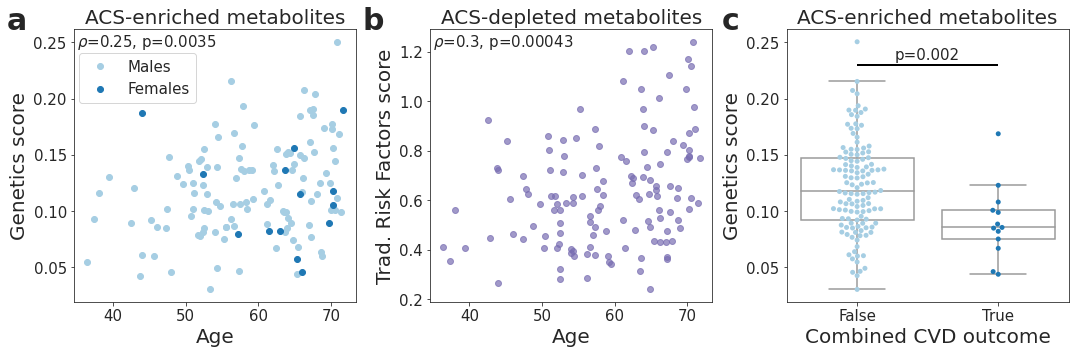

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
c='Age'
r2 = 'Genetics r2'
ax.plot(acs_data_metabolon.loc[acs_data_metabolon['gender']==1][c], bad_acs_metabolomics_origin.loc[acs_data_metabolon['gender']==1][r2], 'o', color=colors[0], label='Males')
ax.plot(acs_data_metabolon.loc[acs_data_metabolon['gender']==0][c], bad_acs_metabolomics_origin.loc[acs_data_metabolon['gender']==0][r2], 'o', color=colors[1], label='Females')
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.set_xlabel(c, fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0] + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([0, 0.01, 0.02, 0.03])
# ax.set_ylim((0, 0.025))
ax.legend(fontsize=tick_fontsize, loc=(0.02, 0.73))
r, p = spearmanr(acs_data_metabolon[c], bad_acs_metabolomics_origin[r2], nan_policy='omit')
add_text_at_corner(ax, r'$\rho$=%0.2g, p=%0.2g'%(r, bad_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)

ax = axes[1]
c='Age'
r2 = 'Traditional Risk Factors r2'
ax.plot(acs_data_metabolon[c], good_acs_metabolomics_origin[r2], 'o', color=feature_colors[r2], alpha=0.7)
ax.set_title('ACS-depleted metabolites', fontsize=labels_fontsize)
ax.set_xlabel(c, fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0].replace('itional', '.') + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)

r, p = spearmanr(acs_data_metabolon[c], good_acs_metabolomics_origin[r2], nan_policy='omit')
add_text_at_corner(ax, r'$\rho$=%0.2g, p=%0.2g'%(r, good_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)

ax = axes[2]
c='combined_cvd_outcome'
r2 = 'Genetics r2'
sns.boxplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=['white'], showfliers=False)
sns.swarmplot(data=pd.concat((acs_data_metabolon[c], bad_acs_metabolomics_origin[r2]), axis=1), x=c, y=r2, ax=ax, palette=colors)
ax.set_title('ACS-enriched metabolites', fontsize=labels_fontsize)
ax.set_xlabel('Combined CVD outcome', fontsize=labels_fontsize)
ax.set_ylabel(r2.split('r2')[0] + 'score', fontsize=labels_fontsize)
ax.tick_params(labelsize=tick_fontsize)
# ax.set_yticks([0, 0.005, 0.01, 0.015, 0.02])
# ax.set_ylim((0, 0.018))
# r, p = spearmanr(acs_data_metabolon[c], bad_acs_metabolomics_origin[r2], nan_policy='omit')
# add_text_at_corner(ax, r'Spearman $\rho$=%0.2g, p=%0.2g'%(r, bad_p.loc[c, r2]), 'top left', fontsize=tick_fontsize)
t, p = mannwhitneyu(bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==1, r2].dropna(), bad_acs_metabolomics_origin.loc[acs_data_metabolon[c]==0, r2].dropna())
xx=0.5
ax.text(xx, 0.235,  'p=%0.1g'%p, ha='center', fontsize=tick_fontsize)
ax.hlines(y=0.23, xmin=xx-0.5, xmax=xx+0.5, linewidth=2, color='black')

fig.tight_layout()
x, y = -0.2, 1.03
plt.text(x, y, 'a', ha='center', va='center', transform=axes[0,].transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')
plt.text(x, y, 'c', ha='center', va='center', transform=axes[2].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'ExtendedDataFigure_age_vs_genetics_and_trad_outcome_vs_genetics_v3.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'ExtendedDataFigure_age_vs_genetics_and_trad_outcome_vs_genetics_v3.pdf'), dpi=300, bbox_inches='tight')

In [1434]:

for c in updated_metabs1[updated_metabs1.SUB_PATHWAY == 'Androgenic Steroids'].index:
    if c not in acs_data_metabolon.columns:
#         print (c)
        continue
    print (c)
    r, p = spearmanr_minimal(metabolomics_origins_acs['ACS-enriched Genetics r2'], acs_data_metabolon.loc[metabolomics_origins_acs.index, c])
#     r, p = spearmanr_minimal(acs_data_metabolon.loc[acs_data_metabolon['gender']==1, 'Age'], acs_data_metabolon.loc[acs_data_metabolon['gender']==1, c])
    if p<0.05:
        print (updated_metabs1.loc[c, 'BIOCHEMICAL'], r, p)

100002126
100002017
5alpha-androstan-3alpha,17beta-diol disulfate 0.3653657847705199 1.3167170777282018e-05
100002018
100002021
100001987
5alpha-androstan-3beta,17beta-diol disulfate 0.33974734172275883 5.544848706798502e-05
100002152
andro steroid monosulfate C19H28O6S (1)* 0.21334357414159583 0.012975148738522579
100002026
100002027
100001992
androstenediol (3beta,17beta) disulfate (1) 0.29337625597502687 0.0005536956909175494
100001994
androstenediol (3beta,17beta) disulfate (2) 0.29920495561408644 0.00042310926921149757
100002028
100002029
androstenediol (3beta,17beta) monosulfate (2) 0.2470952646854112 0.003861842867859963
100001073
100000792
100001287
100005403
X - 12846
100002761
androsterone glucuronide 0.20611324626630542 0.016468603857685903


In [1449]:
circ_heatmap_df_sorted.loc[c]

Healthy-ACS                   -0.040216
DM-ACS                         0.172179
Microbiome r2                  0.000000
Diet r2                        0.001840
Traditional Risk Factors r2    0.000488
Genetics r2                    0.000000
Name: 100002029, dtype: float64

In [1448]:
c = '100002029'
print (spearmanr_minimal(acs_data_metabolon.loc[acs_data_metabolon['gender']==0, 'Age'], acs_data_metabolon.loc[acs_data_metabolon['gender']==0, c]))
print (spearmanr_minimal(acs_data_metabolon.loc[acs_data_metabolon['gender']==1, 'Age'], acs_data_metabolon.loc[acs_data_metabolon['gender']==1, c]))
print (spearmanr_minimal(acs_data_metabolon.loc[:, 'Age'], acs_data_metabolon.loc[:, c]))
print (spearmanr_minimal(metabolomics_origins_acs['ACS-enriched Genetics r2'], acs_data_metabolon.loc[metabolomics_origins_acs.index, c]))

SpearmanrResult(correlation=-0.5298705363272771, pvalue=0.028691674087175965)
SpearmanrResult(correlation=-0.276543630512719, pvalue=0.0009825696880951945)
SpearmanrResult(correlation=-0.3025248225939277, pvalue=0.00012379522045416263)
SpearmanrResult(correlation=0.2470952646854112, pvalue=0.003861842867859963)


COMP_ID                                                                                    37211
                               Group   HMDB_ID                                         HMDB03818
                               Sample   HMDB_ID                                              NaN
BIOCHEMICAL                                        androstenediol (3beta,17beta) monosulfate (1)
CAS                                                                                     521-17-5
CHEMSPIDER                                                                                   NaN
KEGG                                                                                         NaN
MASS                                                                                     369.174
PATHWAY_SORTORDER                                                                           2549
PLATFORM                                                                               LC/MS Neg
PUBCHEM                       

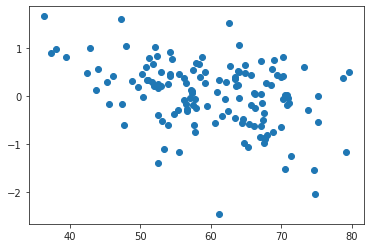

In [91]:
plt.scatter(acs_data_metabolon.loc[acs_data_metabolon['gender']==1, 'Age'], acs_data_metabolon.loc[acs_data_metabolon['gender']==1, '100000792'])
updated_metabs1.loc['100002028']

In [90]:
c='Age'
r2='Genetics r2'
print(spearmanr(acs_data_metabolon.loc[acs_data_metabolon['gender']==1][c], bad_acs_metabolomics_origin.loc[acs_data_metabolon['gender']==1][r2], nan_policy='omit'))
print(spearmanr(acs_data_metabolon.loc[acs_data_metabolon['gender']==0][c], bad_acs_metabolomics_origin.loc[acs_data_metabolon['gender']==0][r2], nan_policy='omit'))

SpearmanrResult(correlation=0.3094069550449771, pvalue=0.0005537935369622389)
SpearmanrResult(correlation=0.015384615384615385, pvalue=0.9583697893719862)


In [1205]:
r2 = 'Microbiome r2'
print (directed_mannwhitneyu(bad_acs_metabolomics_origin[r2].dropna(), good_acs_metabolomics_origin[r2].dropna()))

(99.0, 3.913199098680855e-45)


In [92]:
spearmanr(acs_data_metabolon['combined_cvd_outcome'].astype(float), acs_data_metabolon['Age'], nan_policy='omit')
# acs_data_metabolon['combined_cvd_outcome']
# acs_data_metabolon['combined_cvd_outcome'].astype(float).sum()
# acs_data_metabolon['Age']
print ('age', mannwhitneyu(acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==0].Age.dropna(), acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==1].Age.dropna()))
print ('sex', mannwhitneyu(acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==0].gender.dropna(), acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==1].gender.dropna()))
print ('dm', mannwhitneyu(acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==0]['Glucose Disorder: DM2'].dropna(), 
                           acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==1]['Glucose Disorder: DM2'].dropna()))
print ('smkoking', mannwhitneyu(acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==0]['smoke_tobacco_now'].dropna(), 
                           acs_data_metabolon[acs_data_metabolon.combined_cvd_outcome==1]['smoke_tobacco_now'].dropna()))

age MannwhitneyuResult(statistic=943.0, pvalue=0.08793388699302451)
sex MannwhitneyuResult(statistic=1170.0, pvalue=0.45386152240083194)
dm MannwhitneyuResult(statistic=1004.5, pvalue=0.10900787109779936)
smkoking MannwhitneyuResult(statistic=1116.0, pvalue=0.3431128828948628)


# patients with balanced risk factors

In [424]:

balanced = acs_data_metabolon[(acs_data_metabolon['LDL'] < 100) 
                   & (acs_data_metabolon['HbA1C'] < 6.4) 
                   & (acs_data_metabolon['Admission Diastolic BP']<85) 
                   & (acs_data_metabolon['Admission Systolic BP']<135)
                   & (acs_data_metabolon['smoke_tobacco_now'] == 0)].dropna(subset=['381']).index
not_balanced = acs_data_metabolon.drop(balanced).dropna(subset=['381']).index
# balanced = acs_data_metabolon[(acs_data_metabolon['LDL'] < 70)
#                              & (acs_data_metabolon['HbA1C'] < 6.4) ].dropna(subset=['381']).index
# not_balanced = acs_data_metabolon[(acs_data_metabolon['LDL'] > 100)
#                              & (acs_data_metabolon['HbA1C'] > 6.4) ].dropna(subset=['381']).index
print (balanced.shape, not_balanced.shape)

(11,) (145,)


In [456]:
not_balanced= [
3583645,
3808142,
3154680,
3452236,
3175261,
3211831,
3610441,
3675254,
3637912,
3005299]
balanced=[
3035995,
3826617,
3477351,
3278902,
3304144,
3677285,
3395537,
3447991,
3168327,
3501879,
3587366,
3655837]

In [441]:
acs_data_metabolon[['Age', 'gender', 'LDL', 'HbA1C', 'Admission Diastolic BP', 'Admission Systolic BP', 'smoke_tobacco_now', 'Admission Diagnosis']].to_csv(os.path.join(paper_dir, 'data/', 'acs_data_metabolon_for_Yeela.csv'))

In [436]:
# acs_data_metabolon['LDL'].hist()
# acs_data_metabolon['HbA1C'].hist()
# (acs_data_metabolon['HbA1C'] > 7).sum()
# acs_data_metabolon[acs_data_metabolon['LDL'] >150]['HbA1C']
# not_balanced = acs_data_metabolon[acs_data_metabolon['Glucose Disorder: DM2'] == 1]['HbA1C'].sort_values().dropna().tail(15).index
# balanced = acs_data_metabolon[acs_data_metabolon['Glucose Disorder: DM2'] == 1]['HbA1C'].sort_values().dropna().head(15).index

30

In [460]:
c = 'Diabetes'
directed_mannwhitneyu(bad_acs_metabolomics_origin.loc[not_balanced, c].dropna(), bad_acs_metabolomics_origin.loc[balanced, c].dropna())

(-13.0, 0.0010842842095444344)

In [386]:
good_acs_metabolomics_origin.loc[balanced, c].mean()

0.06231366420515191

In [387]:
good_acs_metabolomics_origin.loc[not_balanced, c].dropna().mean()

0.047824296102918336

In [287]:
df.corr('pearson')

,bad Microbiome r2,bad Diet r2,bad Traditional Risk Factors r2,bad Genetics r2,good Microbiome r2,good Diet r2,good Traditional Risk Factors r2,good Genetics r2
bad Microbiome r2,1.000000,0.684733,0.660738,0.344914,0.019702,0.029650,-0.124376,0.021445
bad Diet r2,0.684733,1.000000,0.628613,0.449553,-0.001483,-0.032510,-0.197376,0.007755
bad Traditional Risk Factors r2,0.660738,0.628613,1.000000,0.445369,-0.039273,-0.085732,-0.234431,-0.139477
bad Genetics r2,0.344914,0.449553,0.445369,1.000000,0.052847,0.020305,0.020200,0.048766
good Microbiome r2,0.019702,-0.001483,-0.039273,0.052847,1.000000,0.953224,0.595989,0.453292
good Diet r2,0.029650,-0.032510,-0.085732,0.020305,0.953224,1.000000,0.728492,0.569968
good Traditional Risk Factors r2,-0.124376,-0.197376,-0.234431,0.020200,0.595989,0.728492,1.000000,0.480978
good Genetics r2,0.021445,0.007755,-0.139477,0.048766,0.453292,0.569968,0.480978,1.000000


In [323]:
spearmanr(acs_data_metabolon.loc[df.index, 'Glucose Disorder: DM2'], df.filter(regex='Trad').min(1), nan_policy='omit')
# acs_data_metabolon['Glucose Disorder: DM2']

SpearmanrResult(correlation=-0.0393334906533399, pvalue=0.6409202424098862)

In [283]:
df.reindex(not_balanced).sort_values('good Diet r2').dropna()

,bad Microbiome r2,bad Diet r2,bad Traditional Risk Factors r2,bad Genetics r2,good Microbiome r2,good Diet r2,good Traditional Risk Factors r2,good Genetics r2
RegistrationCode,,,,,,,,
3973679,0.012455,0.031008,0.065364,0.009004,0.012995,0.024849,0.026775,0.000815
3610542,0.007789,0.023100,0.047576,0.003897,0.011136,0.027659,0.041006,0.003610
3623100,0.014228,0.035654,0.063963,0.004292,0.011381,0.028690,0.016142,0.004637
3819386,0.012183,0.027264,0.071939,0.004445,0.014650,0.028838,0.012176,0.003250
3893636,0.009671,0.027099,0.065229,0.004177,0.013139,0.033161,0.029554,0.002434
...,...,...,...,...,...,...,...,...
3619892,0.011274,0.017152,0.046922,0.004859,0.069070,0.128684,0.071656,0.008429
3935580,0.009461,0.030070,0.049562,0.006375,0.070526,0.131354,0.063584,0.010988
3443343,0.007579,0.020595,0.046086,0.004335,0.070681,0.132330,0.081433,0.009560


In [284]:
df.reindex(balanced).sort_values('good Microbiome r2')

,bad Microbiome r2,bad Diet r2,bad Traditional Risk Factors r2,bad Genetics r2,good Microbiome r2,good Diet r2,good Traditional Risk Factors r2,good Genetics r2
RegistrationCode,,,,,,,,
3956287,0.009357,0.021004,0.049874,0.002628,0.021030,0.047205,0.042877,0.006277
3826617,0.012267,0.029478,0.062503,0.009234,0.022655,0.066683,0.069263,0.004413
3278902,0.007141,0.015891,0.039149,0.002805,0.023142,0.057686,0.055965,0.004168
3477351,0.012376,0.025320,0.074327,0.014824,0.029282,0.057353,0.041552,0.002744
3523680,0.008099,0.021703,0.054167,0.005310,0.037551,0.089602,0.074346,0.006945
3807632,0.010734,0.036327,0.070482,0.006347,0.038403,0.071700,0.044505,0.004971
3655837,0.010782,0.029540,0.064140,0.009126,0.040101,0.087315,0.062203,0.006246
3479343,0.013748,0.024804,0.069099,0.005479,0.043104,0.091636,0.066274,0.005645
3339392,0.008873,0.025377,0.030234,0.006231,0.044558,0.095082,0.080886,0.006010


In [280]:
directed_mannwhitneyu(df.reindex(balanced).dropna()['bad Traditional Risk Factors r2'], df.reindex(not_balanced).dropna()['bad Traditional Risk Factors r2'])
# plt.boxplot([df.reindex(balanced).dropna()['good Traditional Risk Factors r2'], df.reindex(not_balanced).dropna()['good Traditional Risk Factors r2']])

(788.0, 0.33026654948799006)

In [358]:
directed_mannwhitneyu(df['bad Traditional Risk Factors r2'], df['good Traditional Risk Factors r2'])
directed_mannwhitneyu(df['bad Diet r2'], df['good Diet r2'])
directed_mannwhitneyu(df['bad Microbiome r2'], df['good Microbiome r2'])

(214.0, 4.1111261676622465e-47)

In [386]:
pd.concat((circ_heatmap_df_sorted.sort_values('Microbiome r2', ascending=False), 
           updated_metabs1[['SUPER_PATHWAY', 'SUB_PATHWAY', 'BIOCHEMICAL']], 
           get_nlargest_cols(unknowns_sp, 2),
          get_nlargest_cols(full_shap, 5)), axis=1, sort=False).dropna(subset=['Healthy-ACS']).to_csv(os.path.join(metabolon_dir, 'Supplementary_table_metabolites_details.csv'))